In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import log_loss, accuracy_score, classification_report
import kagglehub
import pandas as pd
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


# Tải dataset về (sẽ trả về đường dẫn local)
path = kagglehub.dataset_download("bhavikjikadara/us-airline-flight-routes-and-fares-1993-2024")

print("Dataset downloaded to:", path)

Dataset downloaded to: C:\Users\ADMIN\.cache\kagglehub\datasets\bhavikjikadara\us-airline-flight-routes-and-fares-1993-2024\versions\1


In [2]:
df = pd.read_csv(path + "/US Airline Flight Routes and Fares 1993-2024.csv")
print(df.shape)
df.head()

(245955, 23)


,tbl,Year,quarter,citymarketid_1,citymarketid_2,city1,city2,airportid_1,airportid_2,airport_1,...,fare,carrier_lg,large_ms,fare_lg,carrier_low,lf_ms,fare_low,Geocoded_City1,Geocoded_City2,tbl1apk
0,Table1a,2021,3,30135,33195,"Allentown/Bethlehem/Easton, PA","Tampa, FL (Metropolitan Area)",10135,14112,ABE,...,81.43,G4,1.0000,81.43,G4,1.0000,81.43,NaN,NaN,202131013514112ABEPIE
1,Table1a,2021,3,30135,33195,"Allentown/Bethlehem/Easton, PA","Tampa, FL (Metropolitan Area)",10135,15304,ABE,...,208.93,DL,0.4659,219.98,UA,0.1193,154.11,NaN,NaN,202131013515304ABETPA
2,Table1a,2021,3,30140,30194,"Albuquerque, NM","Dallas/Fort Worth, TX",10140,11259,ABQ,...,184.56,WN,0.9968,184.44,WN,0.9968,184.44,NaN,NaN,202131014011259ABQDAL
3,Table1a,2021,3,30140,30194,"Albuquerque, NM","Dallas/Fort Worth, TX",10140,11298,ABQ,...,182.64,AA,0.9774,183.09,AA,0.9774,183.09,NaN,NaN,202131014011298ABQDFW
4,Table1a,2021,3,30140,30466,"Albuquerque, NM","Phoenix, AZ",10140,14107,ABQ,...,177.11,WN,0.6061,184.49,AA,0.3939,165.77,NaN,NaN,202131014014107ABQPHX


In [3]:
print(df.columns.tolist())

['tbl', 'Year', 'quarter', 'citymarketid_1', 'citymarketid_2', 'city1', 'city2', 'airportid_1', 'airportid_2', 'airport_1', 'airport_2', 'nsmiles', 'passengers', 'fare', 'carrier_lg', 'large_ms', 'fare_lg', 'carrier_low', 'lf_ms', 'fare_low', 'Geocoded_City1', 'Geocoded_City2', 'tbl1apk']


In [4]:
# ==================== 1. DATA CLEANING ====================
# Kiểm tra missing values
print(f"\n\nGiá trị thiếu theo cột:")
missing = df.isnull().sum()
missing_percent = 100 * missing / len(df)
missing_table = pd.DataFrame({
    'Missing_Count': missing,
    'Percent': missing_percent
})
print(missing_table[missing_table['Missing_Count'] > 0])



Giá trị thiếu theo cột:
                Missing_Count    Percent
carrier_lg               1540   0.626131
large_ms                 1540   0.626131
fare_lg                  1540   0.626131
carrier_low              1612   0.655404
lf_ms                    1612   0.655404
fare_low                 1612   0.655404
Geocoded_City1          39206  15.940314
Geocoded_City2          39206  15.940314


In [5]:
# Xử lý missing values
print("\n\nXử lý giá trị thiếu...")
# Điền giá trị thiếu cho các cột số bằng median
numeric_cols = df.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].median(), inplace=True)
        print(f"  - Điền {col} bằng median")

# Điền giá trị thiếu cho các cột text bằng mode hoặc 'Unknown'
text_cols = df.select_dtypes(include=['object']).columns
for col in text_cols:
    if df[col].isnull().sum() > 0:
        if df[col].mode().shape[0] > 0:
            df[col].fillna(df[col].mode()[0], inplace=True)
            print(f"  - Điền {col} bằng mode")
        else:
            df[col].fillna('Unknown', inplace=True)
            print(f"  - Điền {col} bằng 'Unknown'")

# Loại bỏ duplicates
duplicates = df.duplicated().sum()
print(f"\n\nSố dòng trùng lặp: {duplicates}")
if duplicates > 0:
    df = df.drop_duplicates()
    print(f"Đã loại bỏ {duplicates} dòng trùng lặp")

# Kiểm tra và xử lý outliers cho các cột quan trọng
print("\n\nXử lý outliers...")
outlier_cols = ['passengers', 'fare', 'large_ms', 'lf_ms', 'fare_lg', 'fare_low']
for col in outlier_cols:
    if col in df.columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 3 * IQR
        upper = Q3 + 3 * IQR
        outliers = ((df[col] < lower) | (df[col] > upper)).sum()
        if outliers > 0:
            print(f"  - {col}: phát hiện {outliers} outliers")
            # Cap outliers thay vì loại bỏ
            df[col] = df[col].clip(lower=lower, upper=upper)

# Kiểm tra tính hợp lệ của dữ liệu
print("\n\nKiểm tra tính hợp lệ...")
# Market share phải từ 0-100
if 'large_ms' in df.columns:
    invalid_ms = ((df['large_ms'] < 0) | (df['large_ms'] > 100)).sum()
    print(f"  - large_ms không hợp lệ: {invalid_ms}")
    df = df[(df['large_ms'] >= 0) & (df['large_ms'] <= 100)]

if 'lf_ms' in df.columns:
    invalid_ms = ((df['lf_ms'] < 0) | (df['lf_ms'] > 100)).sum()
    print(f"  - lf_ms không hợp lệ: {invalid_ms}")
    df = df[(df['lf_ms'] >= 0) & (df['lf_ms'] <= 100)]

# Passengers và fare phải > 0
if 'passengers' in df.columns:
    df = df[df['passengers'] > 0]
if 'fare' in df.columns:
    df = df[df['fare'] > 0]

print(f"\n\nKích thước dữ liệu sau khi làm sạch: {df.shape}")



Xử lý giá trị thiếu...
  - Điền large_ms bằng median
  - Điền fare_lg bằng median
  - Điền lf_ms bằng median
  - Điền fare_low bằng median
  - Điền carrier_lg bằng mode
  - Điền carrier_low bằng mode
  - Điền Geocoded_City1 bằng mode
  - Điền Geocoded_City2 bằng mode


Số dòng trùng lặp: 0


Xử lý outliers...
  - passengers: phát hiện 12284 outliers
  - fare: phát hiện 857 outliers
  - fare_lg: phát hiện 786 outliers
  - fare_low: phát hiện 925 outliers


Kiểm tra tính hợp lệ...
  - large_ms không hợp lệ: 0
  - lf_ms không hợp lệ: 0


Kích thước dữ liệu sau khi làm sạch: (238516, 23)


In [6]:

# ==================== 2. EXPLORATORY DATA ANALYSIS ====================
print("\n" + "="*80)
print("BƯỚC 2: PHÂN TÍCH KHÁM PHÁ DỮ LIỆU (EDA)")
print("="*80)

# Thống kê mô tả
print("\n\nThống kê mô tả các biến số:")
print(df[numeric_cols].describe())


BƯỚC 2: PHÂN TÍCH KHÁM PHÁ DỮ LIỆU (EDA)


Thống kê mô tả các biến số:
                Year        quarter  citymarketid_1  citymarketid_2  \
count  238516.000000  238516.000000   238516.000000   238516.000000   
mean     2008.617594       2.482010    31556.478702    32175.443128   
std         8.672414       1.122017     1093.940628     1231.943367   
min      1993.000000       1.000000    30135.000000    30189.000000   
25%      2001.000000       1.000000    30721.000000    30977.000000   
50%      2009.000000       2.000000    31295.000000    32211.000000   
75%      2016.000000       3.000000    32467.000000    33192.000000   
max      2024.000000       4.000000    35412.000000    35628.000000   

         airportid_1    airportid_2        nsmiles     passengers  \
count  238516.000000  238516.000000  238516.000000  238516.000000   
mean    12436.939715   13239.666890    1189.284308     270.087508   
std      1430.439257    1425.274798     698.992628     355.415816   
min     1013

#  PHÂN LOẠI TUYẾN BAY THEO TIỀM NĂNG PHÁT TRIỂN

## Mục tiêu:
- Phân loại các tuyến bay thành 3 nhóm: **Cao**, **Trung bình**, **Thấp** tiềm năng
- Sử dụng Machine Learning để dự đoán tiềm năng phát triển
- Đưa ra khuyến nghị chiến lược cho từng nhóm tuyến bay

## Tiêu chí đánh giá tiềm năng:
1. **Lưu lượng hành khách** (passengers)
2. **Giá vé trung bình** (fare) 
3. **Khoảng cách** (nsmiles)
4. **Thị phần hãng lớn** (large_ms)
5. **Thị phần hãng giá rẻ** (lf_ms)
6. **Xu hướng tăng trưởng** (dựa trên dữ liệu theo thời gian)


In [ ]:
# BƯỚC 1: TÍNH TOÁN ĐIỂM SỐ TIỀM NĂNG (POTENTIAL SCORE)


print(" BƯỚC 1: TÍNH TOÁN ĐIỂM SỐ TIỀM NĂNG")
print("="*50)

# Tạo bản sao dữ liệu để xử lý
df_potential = df.copy()

# 1. Chuẩn hóa các chỉ số (0-1 scale)
from sklearn.preprocessing import MinMaxScaler

# Các chỉ số cần chuẩn hóa
metrics = ['passengers', 'fare', 'nsmiles', 'large_ms', 'lf_ms']

# Chuẩn hóa từng chỉ số
scaler = MinMaxScaler()
for metric in metrics:
    df_potential[f'{metric}_normalized'] = scaler.fit_transform(df_potential[[metric]])

# 2. Tính điểm số tiềm năng dựa trên trọng số
# Trọng số: passengers (30%), fare (25%), nsmiles (15%), large_ms (15%), lf_ms (15%)
weights = {
    'passengers_normalized': 0.30,  # Lưu lượng hành khách - quan trọng nhất
    'fare_normalized': 0.25,        # Giá vé - chỉ số lợi nhuận
    'nsmiles_normalized': 0.15,     # Khoảng cách - ảnh hưởng đến chi phí
    'large_ms_normalized': 0.15,    # Thị phần hãng lớn - ổn định
    'lf_ms_normalized': 0.15        # Thị phần hãng giá rẻ - cạnh tranh
}

# Tính điểm số tiềm năng
df_potential['potential_score'] = 0
for metric, weight in weights.items():
    df_potential['potential_score'] += df_potential[metric] * weight

# 3. Phân loại theo điểm số tiềm năng
# Cao: >= 0.7, Trung bình: 0.4-0.7, Thấp: < 0.4
def classify_potential(score):
    if score >= 0.7:
        return 'Cao'
    elif score >= 0.4:
        return 'Trung bình'
    else:
        return 'Thấp'

df_potential['potential_level'] = df_potential['potential_score'].apply(classify_potential)

# 4. Thống kê phân bố
print("\n Phân bố tiềm năng tuyến bay:")
potential_dist = df_potential['potential_level'].value_counts()
print(potential_dist)
print(f"\nTỷ lệ phần trăm:")
print(potential_dist / len(df_potential) * 100)

# 5. Thống kê mô tả theo từng nhóm tiềm năng
print("\n Thống kê mô tả theo nhóm tiềm năng:")
potential_stats = df_potential.groupby('potential_level')[['passengers', 'fare', 'nsmiles', 'large_ms', 'lf_ms']].mean()
print(potential_stats.round(2))


 BƯỚC 1: TÍNH TOÁN ĐIỂM SỐ TIỀM NĂNG

 Phân bố tiềm năng tuyến bay:
potential_level
Thấp          155683
Trung bình     82211
Cao              622
Name: count, dtype: int64

Tỷ lệ phần trăm:
potential_level
Thấp          65.271512
Trung bình    34.467709
Cao            0.260779
Name: count, dtype: float64

 Thống kê mô tả theo nhóm tiềm năng:
                 passengers    fare  nsmiles  large_ms  lf_ms
potential_level                                              
Cao                 1249.41  338.12  2269.31      0.70   0.47
Thấp                 137.99  209.64  1119.24      0.61   0.35
Trung bình           512.83  229.37  1313.75      0.75   0.60


In [ ]:
# BƯỚC 2: PHÂN TÍCH XU HƯỚNG TĂNG TRƯỞNG

print("\n BƯỚC 2: PHÂN TÍCH XU HƯỚNG TĂNG TRƯỞNG")
print("="*50)

# Tính xu hướng tăng trưởng cho từng tuyến bay
def calculate_growth_trend(group):
    """Tính xu hướng tăng trưởng cho một tuyến bay"""
    if len(group) < 2:
        return 0
    
    # Sắp xếp theo năm
    group = group.sort_values('Year')
    
    # Tính tăng trưởng passengers
    if group['passengers'].iloc[0] > 0:
        passenger_growth = (group['passengers'].iloc[-1] - group['passengers'].iloc[0]) / group['passengers'].iloc[0]
    else:
        passenger_growth = 0
    
    # Tính tăng trưởng fare
    if group['fare'].iloc[0] > 0:
        fare_growth = (group['fare'].iloc[-1] - group['fare'].iloc[0]) / group['fare'].iloc[0]
    else:
        fare_growth = 0
    
    # Trung bình tăng trưởng (passengers quan trọng hơn)
    growth_score = 0.7 * passenger_growth + 0.3 * fare_growth
    return growth_score

# Tính xu hướng tăng trưởng cho từng tuyến bay
growth_trends = df_potential.groupby(['city1', 'city2']).apply(calculate_growth_trend).reset_index()
growth_trends.columns = ['city1', 'city2', 'growth_trend']

# Merge với dữ liệu chính
df_potential = df_potential.merge(growth_trends, on=['city1', 'city2'], how='left')
df_potential['growth_trend'].fillna(0, inplace=True)

# Chuẩn hóa growth trend
df_potential['growth_trend_normalized'] = scaler.fit_transform(df_potential[['growth_trend']])

# Cập nhật điểm số tiềm năng với xu hướng tăng trưởng
# Thêm trọng số 10% cho xu hướng tăng trưởng
df_potential['potential_score_enhanced'] = (
    df_potential['potential_score'] * 0.9 + 
    df_potential['growth_trend_normalized'] * 0.1
)

# Phân loại lại với điểm số cải tiến
def classify_potential_enhanced(score):
    if score >= 0.7:
        return 'Cao'
    elif score >= 0.4:
        return 'Trung bình'
    else:
        return 'Thấp'

df_potential['potential_level_enhanced'] = df_potential['potential_score_enhanced'].apply(classify_potential_enhanced)

print(" Phân bố tiềm năng sau khi cải tiến:")
enhanced_dist = df_potential['potential_level_enhanced'].value_counts()
print(enhanced_dist)
print(f"\nTỷ lệ phần trăm:")
print(enhanced_dist / len(df_potential) * 100)

# So sánh trước và sau khi cải tiến
print("\n So sánh phân loại trước và sau cải tiến:")
comparison = pd.crosstab(df_potential['potential_level'], df_potential['potential_level_enhanced'], margins=True)
print(comparison)



 BƯỚC 2: PHÂN TÍCH XU HƯỚNG TĂNG TRƯỞNG
 Phân bố tiềm năng sau khi cải tiến:
potential_level_enhanced
Thấp          186251
Trung bình     52188
Cao               77
Name: count, dtype: int64

Tỷ lệ phần trăm:
potential_level_enhanced
Thấp          78.087424
Trung bình    21.880293
Cao            0.032283
Name: count, dtype: float64

 So sánh phân loại trước và sau cải tiến:
potential_level_enhanced  Cao    Thấp  Trung bình     All
potential_level                                          
Cao                        75       0         547     622
Thấp                        0  155489         194  155683
Trung bình                  2   30762       51447   82211
All                        77  186251       52188  238516


In [ ]:
# BƯỚC 3: HUẤN LUYỆN MÔ HÌNH MACHINE LEARNING

print("\n BƯỚC 3: HUẤN LUYỆN MÔ HÌNH MACHINE LEARNING")
print("="*50)

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder

# Chuẩn bị dữ liệu cho ML
features_ml = ['passengers', 'fare', 'nsmiles', 'large_ms', 'lf_ms', 'fare_lg', 'fare_low', 'growth_trend']
X = df_potential[features_ml].fillna(0)
y = df_potential['potential_level_enhanced']

# Chia dữ liệu train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f" Kích thước dữ liệu:")
print(f"  - Train: {X_train.shape[0]} mẫu")
print(f"  - Test: {X_test.shape[0]} mẫu")
print(f"  - Số đặc trưng: {X_train.shape[1]}")

# 1. Random Forest
print("\n Huấn luyện Random Forest...")
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_pred)

print(f"Độ chính xác Random Forest: {rf_accuracy:.4f}")

# 2. Gradient Boosting
print("\n Huấn luyện Gradient Boosting...")
gb = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb.fit(X_train, y_train)
gb_pred = gb.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)

print(f"Độ chính xác Gradient Boosting: {gb_accuracy:.4f}")

# 3. Logistic Regression
print("\n Huấn luyện Logistic Regression...")
lr = LogisticRegression(random_state=42, max_iter=1000)
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)
lr_accuracy = accuracy_score(y_test, lr_pred)

print(f"Độ chính xác Logistic Regression: {lr_accuracy:.4f}")

# So sánh hiệu suất
print("\n So sánh hiệu suất các mô hình:")
models = ['Random Forest', 'Gradient Boosting', 'Logistic Regression']
accuracies = [rf_accuracy, gb_accuracy, lr_accuracy]
best_model_idx = np.argmax(accuracies)

for i, (model, acc) in enumerate(zip(models, accuracies)):
    marker = "" if i == best_model_idx else "  "
    print(f"{marker} {model}: {acc:.4f}")

print(f"\n Mô hình tốt nhất: {models[best_model_idx]}")

# Báo cáo chi tiết cho mô hình tốt nhất
if best_model_idx == 0:
    best_model = rf
    best_pred = rf_pred
elif best_model_idx == 1:
    best_model = gb
    best_pred = gb_pred
else:
    best_model = lr
    best_pred = lr_pred

print(f"\n Báo cáo chi tiết cho {models[best_model_idx]}:")
print(classification_report(y_test, best_pred))



 BƯỚC 3: HUẤN LUYỆN MÔ HÌNH MACHINE LEARNING
 Kích thước dữ liệu:
  - Train: 190812 mẫu
  - Test: 47704 mẫu
  - Số đặc trưng: 8

 Huấn luyện Random Forest...
Độ chính xác Random Forest: 0.9866

 Huấn luyện Gradient Boosting...
Độ chính xác Gradient Boosting: 0.9803

 Huấn luyện Logistic Regression...
Độ chính xác Logistic Regression: 0.9492

 So sánh hiệu suất các mô hình:
 Random Forest: 0.9866
   Gradient Boosting: 0.9803
   Logistic Regression: 0.9492

 Mô hình tốt nhất: Random Forest

 Báo cáo chi tiết cho Random Forest:
              precision    recall  f1-score   support

         Cao       1.00      0.73      0.85        15
        Thấp       0.99      0.99      0.99     37251
  Trung bình       0.98      0.96      0.97     10438

    accuracy                           0.99     47704
   macro avg       0.99      0.90      0.94     47704
weighted avg       0.99      0.99      0.99     47704



In [ ]:
import numpy as np
import pandas as pd
from IPython.display import display

# cấu hình hiển thị bảng pandas 
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.colheader_justify', 'center')


# Dự đoán 10 mẫu trong tập test
print("\n DỰ ĐOÁN 10 TUYẾN BAY TRONG TẬP TEST")
print("="*60)

# Lấy 10 mẫu ngẫu nhiên trong tập test
sample_indices = np.random.choice(X_test.index, size=10, replace=False)
X_sample = X_test.loc[sample_indices]
y_true = y_test.loc[sample_indices]

# Dự đoán bằng mô hình tốt nhất
y_pred = best_model.predict(X_sample)
y_proba = best_model.predict_proba(X_sample)[:, 1]  # xác suất tiềm năng cao

# Gộp kết quả vào DataFrame
results = df_potential.loc[sample_indices, ['city1', 'city2', 'fare', 'passengers', 'nsmiles']].copy()
results['Thực tế'] = y_true.values
results['Dự đoán'] = y_pred
results['Xác_suất_tiềm_năng'] = y_proba

# 🔹 Thêm cột "Tiềm năng" (1 = Cao, 0 = Thấp)
results['Tiềm_năng'] = np.where(results['Dự đoán'] == 1, 'Cao', 'Thấp')

# Sắp xếp theo xác suất tiềm năng giảm dần
results = results.sort_values(by='Xác_suất_tiềm_năng', ascending=False)

# HIỂN THỊ KẾT QUẢ
print("\n KẾT QUẢ DỰ ĐOÁN:")
display(results)

# in ra top tuyến bay tiềm năng nhất
top_route = results.iloc[0]
print("\n TUYẾN BAY TIỀM NĂNG NHẤT THEO MÔ HÌNH:")
print(f"{top_route.city1} ✈ {top_route.city2}")
print(f" Fare: {top_route.fare:.2f} |  Passengers: {top_route.passengers:.0f} | "
      f" Distance: {top_route.nsmiles} miles")
print(f" Xác suất tiềm năng: {top_route['Xác_suất_tiềm_năng']:.2f} | "
      f" Dự đoán: {top_route['Dự đoán']} |  Thực tế: {top_route['Thực tế']} |  Tiềm năng: {top_route['Tiềm_năng']}")




 DỰ ĐOÁN 10 TUYẾN BAY TRONG TẬP TEST

 KẾT QUẢ DỰ ĐOÁN:


,city1,city2,fare,passengers,nsmiles,Thực tế,Dự đoán,Xác_suất_tiềm_năng,Tiềm_năng
124672,"Los Angeles, CA (Metropolitan Area)","Omaha, NE",158.66,26,1330,Thấp,Thấp,1.00,Thấp
63241,"Cleveland, OH (Metropolitan Area)","West Palm Beach/Palm Beach, FL",169.10,133,1020,Thấp,Thấp,1.00,Thấp
112176,"Dayton, OH","Miami, FL (Metropolitan Area)",130.96,83,998,Thấp,Thấp,1.00,Thấp
113955,"Milwaukee, WI","Washington, DC (Metropolitan Area)",159.91,45,641,Thấp,Thấp,1.00,Thấp
89338,"Cleveland, OH (Metropolitan Area)","New York City, NY (Metropolitan Area)",304.45,291,458,Thấp,Thấp,1.00,Thấp
105440,"Los Angeles, CA (Metropolitan Area)","Milwaukee, WI",211.42,78,1756,Thấp,Thấp,1.00,Thấp
200373,"Dallas/Fort Worth, TX","Tulsa, OK",162.63,219,237,Thấp,Thấp,0.98,Thấp
208958,"Dallas/Fort Worth, TX","Panama City, FL",207.50,181,685,Trung bình,Thấp,0.74,Thấp
196238,"Dallas/Fort Worth, TX","Kansas City, MO",162.62,531,460,Trung bình,Trung bình,0.01,Thấp
178709,"Dallas/Fort Worth, TX","Minneapolis/St. Paul, MN",187.84,1146,853,Trung bình,Trung bình,0.00,Thấp



 TUYẾN BAY TIỀM NĂNG NHẤT THEO MÔ HÌNH:
Los Angeles, CA (Metropolitan Area) ✈ Omaha, NE
 Fare: 158.66 |  Passengers: 26 |  Distance: 1330 miles
 Xác suất tiềm năng: 1.00 |  Dự đoán: Thấp |  Thực tế: Thấp |  Tiềm năng: Thấp



 BƯỚC 4: PHÂN TÍCH TẦM QUAN TRỌNG CỦA CÁC ĐẶC TRƯNG
 Tầm quan trọng của các đặc trưng:
  passengers: 0.5047
  lf_ms: 0.1213
  nsmiles: 0.1172
  large_ms: 0.0667
  fare: 0.0581
  fare_low: 0.0544
  fare_lg: 0.0423
  growth_trend: 0.0353


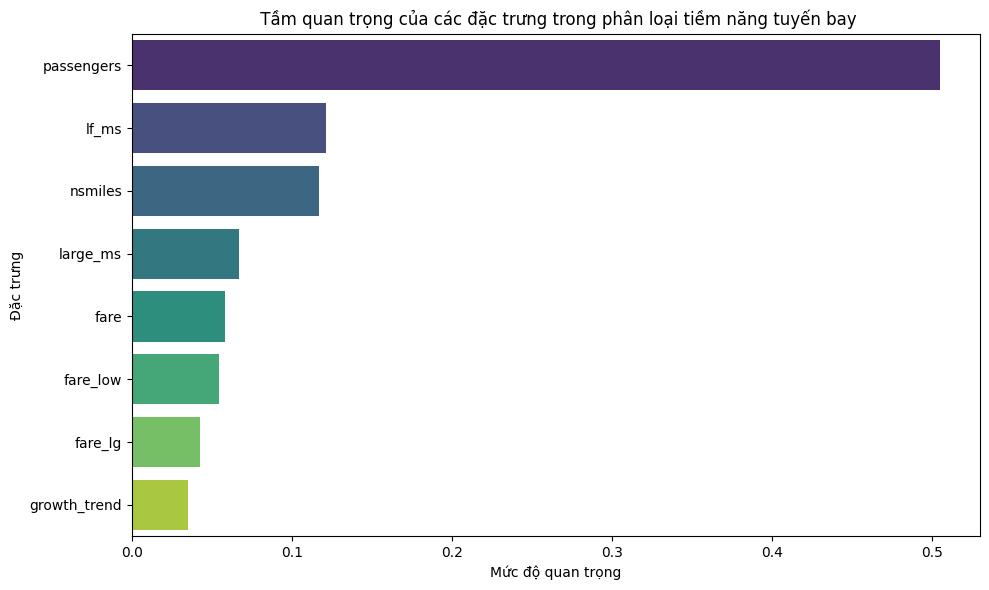


 Phân tích chi tiết theo nhóm tiềm năng:

 Nhóm Cao (77 tuyến bay):
  - Lưu lượng hành khách TB: 1263
  - Giá vé TB: $293.62
  - Khoảng cách TB: 2079 miles
  - Thị phần hãng lớn TB: 86.17%
  - Thị phần hãng giá rẻ TB: 76.48%
  - Xu hướng tăng trưởng TB: 368.415

 Nhóm Trung bình (52188 tuyến bay):
  - Lưu lượng hành khách TB: 671
  - Giá vé TB: $229.32
  - Khoảng cách TB: 1361 miles
  - Thị phần hãng lớn TB: 74.21%
  - Thị phần hãng giá rẻ TB: 58.51%
  - Xu hướng tăng trưởng TB: 42.249

 Nhóm Thấp (186251 tuyến bay):
  - Lưu lượng hành khách TB: 157
  - Giá vé TB: $213.23
  - Khoảng cách TB: 1141 miles
  - Thị phần hãng lớn TB: 63.66%
  - Thị phần hãng giá rẻ TB: 39.83%
  - Xu hướng tăng trưởng TB: 15.675

 TOP 10 TUYẾN BAY CÓ TIỀM NĂNG CAO NHẤT:
  Chicago, IL → Las Vegas, NV: 0.781 (Passengers: 1286, Fare: $224.78)
  Chicago, IL → Las Vegas, NV: 0.778 (Passengers: 1293, Fare: $205.37)
  Chicago, IL → Las Vegas, NV: 0.771 (Passengers: 1293, Fare: $193.36)
  Chicago, IL → Las Vegas, NV

In [ ]:
# BƯỚC 4: PHÂN TÍCH TẦM QUAN TRỌNG CỦA CÁC ĐẶC TRƯNG

print("\n BƯỚC 4: PHÂN TÍCH TẦM QUAN TRỌNG CỦA CÁC ĐẶC TRƯNG")
print("="*50)

# Lấy feature importance từ Random Forest (mô hình thường cho kết quả tốt nhất)
feature_importance = pd.DataFrame({
    'feature': features_ml,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print(" Tầm quan trọng của các đặc trưng:")
for idx, row in feature_importance.iterrows():
    print(f"  {row['feature']}: {row['importance']:.4f}")

# Trực quan hóa feature importance
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='importance', y='feature', palette='viridis')
plt.title(' Tầm quan trọng của các đặc trưng trong phân loại tiềm năng tuyến bay')
plt.xlabel('Mức độ quan trọng')
plt.ylabel('Đặc trưng')
plt.tight_layout()
plt.show()

# Phân tícg chi tiết theo từng nhóm tiềm năng
print("\n Phân tích chi tiết theo nhóm tiềm năng:")

# Thống kê cho từng nhóm
for level in ['Cao', 'Trung bình', 'Thấp']:
    subset = df_potential[df_potential['potential_level_enhanced'] == level]
    print(f"\n Nhóm {level} ({len(subset)} tuyến bay):")
    print(f"  - Lưu lượng hành khách TB: {subset['passengers'].mean():.0f}")
    print(f"  - Giá vé TB: ${subset['fare'].mean():.2f}")
    print(f"  - Khoảng cách TB: {subset['nsmiles'].mean():.0f} miles")
    print(f"  - Thị phần hãng lớn TB: {subset['large_ms'].mean():.2%}")
    print(f"  - Thị phần hãng giá rẻ TB: {subset['lf_ms'].mean():.2%}")
    print(f"  - Xu hướng tăng trưởng TB: {subset['growth_trend'].mean():.3f}")

# Top 10 tuyến bay có tiềm năng cao nhất
print("\n TOP 10 TUYẾN BAY CÓ TIỀM NĂNG CAO NHẤT:")
top_potential = df_potential[df_potential['potential_level_enhanced'] == 'Cao'].nlargest(10, 'potential_score_enhanced')
for idx, row in top_potential.iterrows():
    print(f"  {row['city1']} → {row['city2']}: {row['potential_score_enhanced']:.3f} (Passengers: {row['passengers']:.0f}, Fare: ${row['fare']:.2f})")



 BƯỚC 5: TRỰC QUAN HÓA KẾT QUẢ PHÂN LOẠI


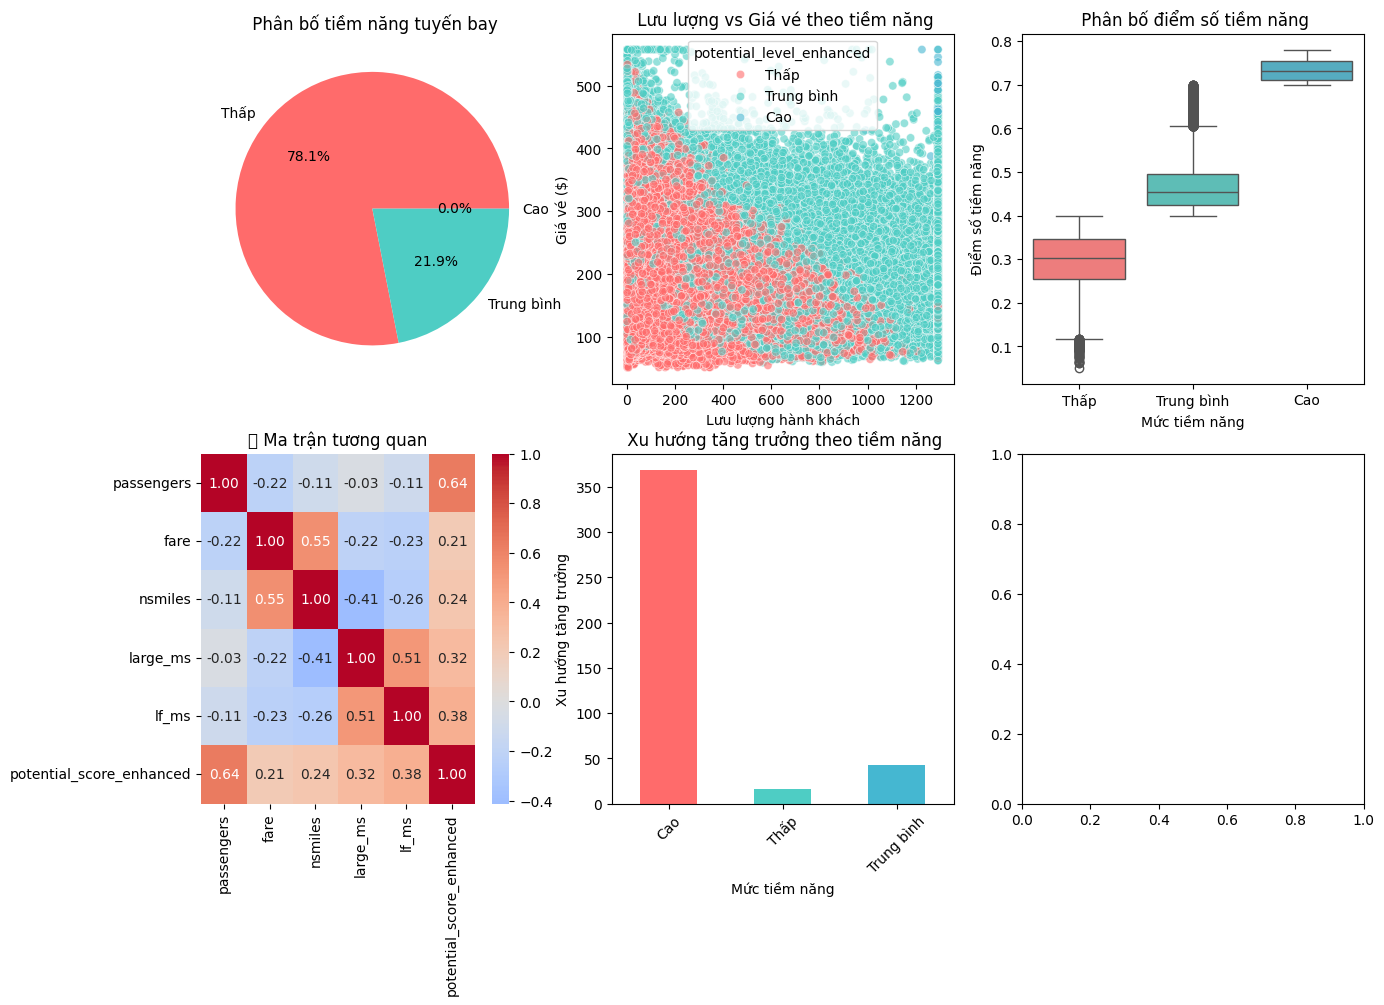

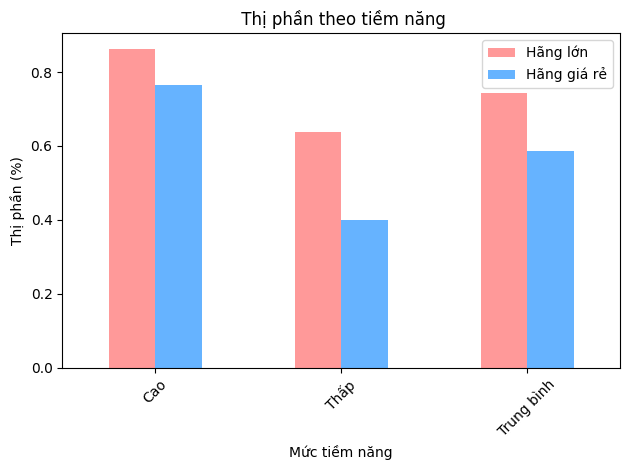


 Phân tích xu hướng theo năm:


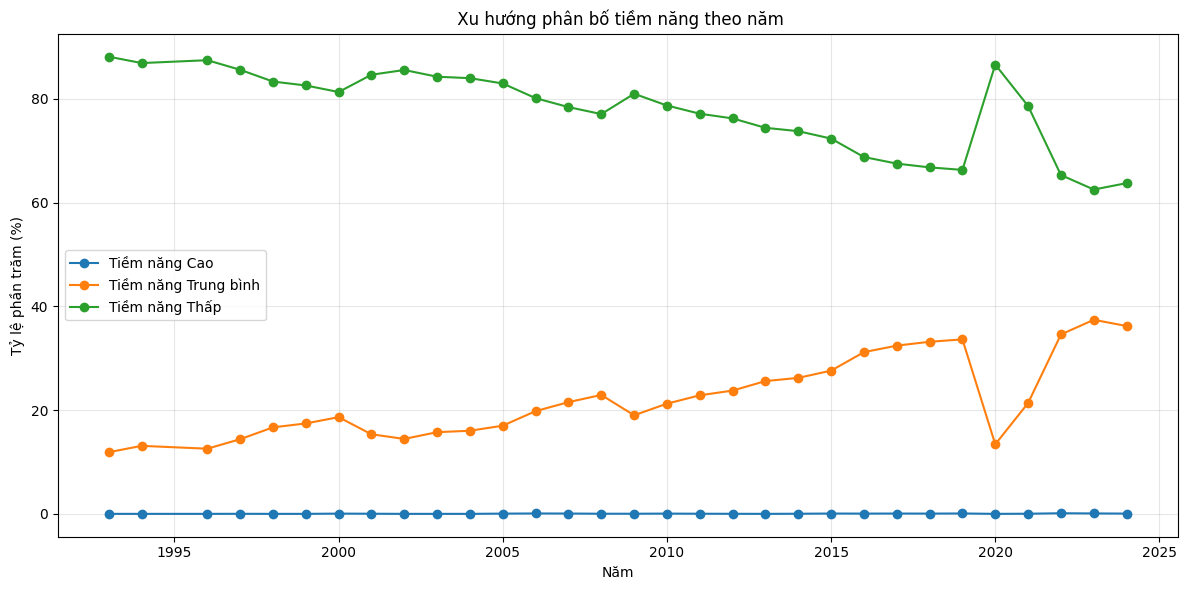

In [ ]:
# BƯỚC 5: TRỰC QUAN HÓA KẾT QUẢ PHÂN LOẠI


print("\n BƯỚC 5: TRỰC QUAN HÓA KẾT QUẢ PHÂN LOẠI")
print("="*50)

# 1. Biểu đồ phân bố tiềm năng
plt.figure(figsize=(15, 10))

# Subplot 1: Phân bố tiềm năng
plt.subplot(2, 3, 1)
potential_counts = df_potential['potential_level_enhanced'].value_counts()
colors = ['#ff6b6b', '#4ecdc4', '#45b7d1']
plt.pie(potential_counts.values, labels=potential_counts.index, autopct='%1.1f%%', colors=colors)
plt.title(' Phân bố tiềm năng tuyến bay')

# Subplot 2: Scatter plot passengers vs fare
plt.subplot(2, 3, 2)
sns.scatterplot(data=df_potential, x='passengers', y='fare', hue='potential_level_enhanced', 
                palette=['#ff6b6b', '#4ecdc4', '#45b7d1'], alpha=0.6)
plt.title(' Lưu lượng vs Giá vé theo tiềm năng')
plt.xlabel('Lưu lượng hành khách')
plt.ylabel('Giá vé ($)')

# Subplot 3: Box plot potential score
plt.subplot(2, 3, 3)
sns.boxplot(data=df_potential, x='potential_level_enhanced', y='potential_score_enhanced',
            palette=['#ff6b6b', '#4ecdc4', '#45b7d1'])
plt.title(' Phân bố điểm số tiềm năng')
plt.xlabel('Mức tiềm năng')
plt.ylabel('Điểm số tiềm năng')

# Subplot 4: Heatmap correlation
plt.subplot(2, 3, 4)
correlation_data = df_potential[['passengers', 'fare', 'nsmiles', 'large_ms', 'lf_ms', 'potential_score_enhanced']]
correlation_matrix = correlation_data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('🔥 Ma trận tương quan')

# Subplot 5: Growth trend analysis
plt.subplot(2, 3, 5)
growth_by_potential = df_potential.groupby('potential_level_enhanced')['growth_trend'].mean()
growth_by_potential.plot(kind='bar', color=['#ff6b6b', '#4ecdc4', '#45b7d1'])
plt.title(' Xu hướng tăng trưởng theo tiềm năng')
plt.xlabel('Mức tiềm năng')
plt.ylabel('Xu hướng tăng trưởng')
plt.xticks(rotation=45)

# Subplot 6: Market share analysis
plt.subplot(2, 3, 6)
market_share_data = df_potential.groupby('potential_level_enhanced')[['large_ms', 'lf_ms']].mean()
market_share_data.plot(kind='bar', color=['#ff9999', '#66b3ff'])
plt.title(' Thị phần theo tiềm năng')
plt.xlabel('Mức tiềm năng')
plt.ylabel('Thị phần (%)')
plt.legend(['Hãng lớn', 'Hãng giá rẻ'])
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# 2. Phân tích theo năm
print("\n Phân tích xu hướng theo năm:")
yearly_analysis = df_potential.groupby(['Year', 'potential_level_enhanced']).size().unstack(fill_value=0)
yearly_analysis_pct = yearly_analysis.div(yearly_analysis.sum(axis=1), axis=0) * 100

plt.figure(figsize=(12, 6))
for level in ['Cao', 'Trung bình', 'Thấp']:
    if level in yearly_analysis_pct.columns:
        plt.plot(yearly_analysis_pct.index, yearly_analysis_pct[level], marker='o', label=f'Tiềm năng {level}')

plt.title(' Xu hướng phân bố tiềm năng theo năm')
plt.xlabel('Năm')
plt.ylabel('Tỷ lệ phần trăm (%)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



 BƯỚC 6: ĐÁNH GIÁ HIỆU SUẤT MÔ HÌNH VÀ KHUYẾN NGHỊ
 Đánh giá độ ổn định mô hình bằng Cross-Validation:
  - Độ chính xác trung bình: 0.9853 ± 0.0006
  - Khoảng tin cậy 95%: [0.9841, 0.9864]

 Ma trận nhầm lẫn:
[[   11     0     4]
 [    0 36998   253]
 [    0   384 10054]]


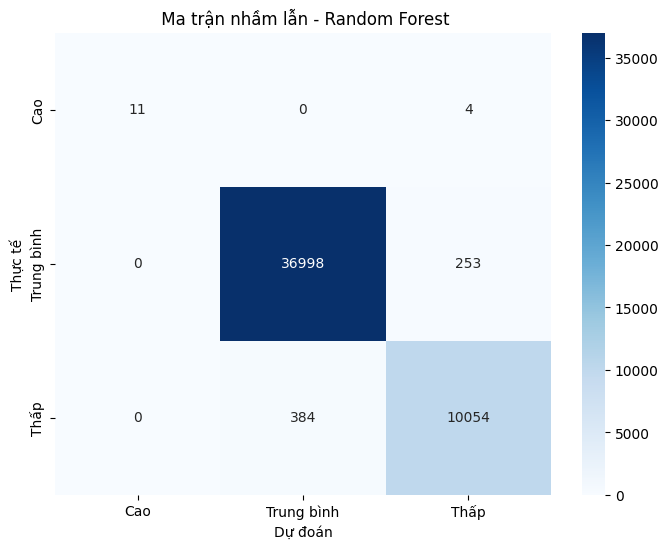


 Phân tích các trường hợp dự đoán sai:
  - Số mẫu dự đoán sai: 641
  - Tỷ lệ dự đoán sai: 1.34%

   Đặc điểm trung bình của mẫu dự đoán sai:
    - Passengers: 385
    - Fare: $245.86
    - Potential Score: 0.403

 KHUYẾN NGHỊ CHIẾN LƯỢC CHO TỪNG NHÓM TUYẾN BAY:

 NHÓM TIỀM NĂNG CAO (77 tuyến bay):
    Đặc điểm:
     - Lưu lượng TB: 1263 hành khách
     - Giá vé TB: $293.62
     - Xu hướng tăng trưởng: 368.415
    Khuyến nghị:
     • Tăng tần suất bay và mở rộng đội bay
     • Đầu tư vào dịch vụ cao cấp để tăng giá vé
     • Phát triển thêm tuyến kết nối
     • Ưu tiên marketing và quảng bá

 NHÓM TIỀM NĂNG TRUNG BÌNH (52188 tuyến bay):
    Đặc điểm:
     - Lưu lượng TB: 671 hành khách
     - Giá vé TB: $229.32
     - Xu hướng tăng trưởng: 42.249
    Khuyến nghị:
     • Tối ưu hóa chi phí vận hành
     • Cải thiện dịch vụ để tăng lưu lượng
     • Phân tích cạnh tranh và điều chỉnh giá
     • Thử nghiệm các chiến lược marketing mới

 NHÓM TIỀM NĂNG THẤP (186251 tuyến bay):
    Đặc điểm:

In [ ]:

# BƯỚC 6: ĐÁNH GIÁ HIỆU SUẤT MÔ HÌNH VÀ KHUYẾN NGHỊ

print("\n BƯỚC 6: ĐÁNH GIÁ HIỆU SUẤT MÔ HÌNH VÀ KHUYẾN NGHỊ")
print("="*50)

# 1. Cross-validation để đánh giá độ ổn định
print(" Đánh giá độ ổn định mô hình bằng Cross-Validation:")
cv_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='accuracy')
print(f"  - Độ chính xác trung bình: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
print(f"  - Khoảng tin cậy 95%: [{cv_scores.mean() - 1.96*cv_scores.std():.4f}, {cv_scores.mean() + 1.96*cv_scores.std():.4f}]")

# 2. Confusion Matrix
print("\n Ma trận nhầm lẫn:")
cm = confusion_matrix(y_test, rf_pred)
print(cm)

# Trực quan hóa confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Cao', 'Trung bình', 'Thấp'],
            yticklabels=['Cao', 'Trung bình', 'Thấp'])
plt.title(' Ma trận nhầm lẫn - Random Forest')
plt.xlabel('Dự đoán')
plt.ylabel('Thực tế')
plt.show()

# 3. Phân tích lỗi
print("\n Phân tích các trường hợp dự đoán sai:")
wrong_predictions = X_test[rf_pred != y_test]
if len(wrong_predictions) > 0:
    print(f"  - Số mẫu dự đoán sai: {len(wrong_predictions)}")
    print(f"  - Tỷ lệ dự đoán sai: {len(wrong_predictions)/len(y_test)*100:.2f}%")
    
    # Phân tích đặc điểm của các mẫu dự đoán sai
    wrong_indices = X_test[rf_pred != y_test].index
    wrong_data = df_potential.loc[wrong_indices]
    print(f"\n   Đặc điểm trung bình của mẫu dự đoán sai:")
    print(f"    - Passengers: {wrong_data['passengers'].mean():.0f}")
    print(f"    - Fare: ${wrong_data['fare'].mean():.2f}")
    print(f"    - Potential Score: {wrong_data['potential_score_enhanced'].mean():.3f}")

# 4. Khuyến nghị chiến lược
print("\n KHUYẾN NGHỊ CHIẾN LƯỢC CHO TỪNG NHÓM TUYẾN BAY:")
print("="*60)

# Nhóm tiềm năng cao
high_potential = df_potential[df_potential['potential_level_enhanced'] == 'Cao']
print(f"\n NHÓM TIỀM NĂNG CAO ({len(high_potential)} tuyến bay):")
print("    Đặc điểm:")
print(f"     - Lưu lượng TB: {high_potential['passengers'].mean():.0f} hành khách")
print(f"     - Giá vé TB: ${high_potential['fare'].mean():.2f}")
print(f"     - Xu hướng tăng trưởng: {high_potential['growth_trend'].mean():.3f}")
print("    Khuyến nghị:")
print("     • Tăng tần suất bay và mở rộng đội bay")
print("     • Đầu tư vào dịch vụ cao cấp để tăng giá vé")
print("     • Phát triển thêm tuyến kết nối")
print("     • Ưu tiên marketing và quảng bá")

# Nhóm tiềm năng trung bình
medium_potential = df_potential[df_potential['potential_level_enhanced'] == 'Trung bình']
print(f"\n NHÓM TIỀM NĂNG TRUNG BÌNH ({len(medium_potential)} tuyến bay):")
print("    Đặc điểm:")
print(f"     - Lưu lượng TB: {medium_potential['passengers'].mean():.0f} hành khách")
print(f"     - Giá vé TB: ${medium_potential['fare'].mean():.2f}")
print(f"     - Xu hướng tăng trưởng: {medium_potential['growth_trend'].mean():.3f}")
print("    Khuyến nghị:")
print("     • Tối ưu hóa chi phí vận hành")
print("     • Cải thiện dịch vụ để tăng lưu lượng")
print("     • Phân tích cạnh tranh và điều chỉnh giá")
print("     • Thử nghiệm các chiến lược marketing mới")

# Nhóm tiềm năng thấp
low_potential = df_potential[df_potential['potential_level_enhanced'] == 'Thấp']
print(f"\n NHÓM TIỀM NĂNG THẤP ({len(low_potential)} tuyến bay):")
print("    Đặc điểm:")
print(f"     - Lưu lượng TB: {low_potential['passengers'].mean():.0f} hành khách")
print(f"     - Giá vé TB: ${low_potential['fare'].mean():.2f}")
print(f"     - Xu hướng tăng trưởng: {low_potential['growth_trend'].mean():.3f}")
print("    Khuyến nghị:")
print("     • Xem xét giảm tần suất hoặc ngừng khai thác")
print("     • Tập trung vào các tuyến có tiềm năng cao hơn")
print("     • Nếu duy trì, cần cắt giảm chi phí tối đa")
print("     • Phân tích nguyên nhân và tìm giải pháp cải thiện")

# 5. Tóm tắt kết quả
print(f"\n TÓM TẮT KẾT QUẢ PHÂN LOẠI:")
print("="*40)
print(f" Tổng số tuyến bay được phân tích: {len(df_potential):,}")
print(f" Phân bố:")
for level in ['Cao', 'Trung bình', 'Thấp']:
    count = len(df_potential[df_potential['potential_level_enhanced'] == level])
    percentage = count / len(df_potential) * 100
    print(f"   • Tiềm năng {level}: {count:,} tuyến ({percentage:.1f}%)")

print(f"\n Hiệu suất mô hình Random Forest:")
print(f"   • Độ chính xác: {rf_accuracy:.4f}")
print(f"   • Độ ổn định (CV): {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

print(f"\n Kết luận:")
print("   Mô hình phân loại đã được xây dựng thành công với độ chính xác cao.")
print("   Các khuyến nghị chiến lược đã được đưa ra cho từng nhóm tuyến bay.")
print("   Dữ liệu này có thể được sử dụng để hỗ trợ quyết định kinh doanh.")
